# Unstructured Data Analysis-Final Project: Harry Potter and Friends (?)
## Character Networks and Social Networks


### Table of Contents
1. [Load Data](#data)
1. [Character Network: Co-Occurence](#widget)
1. [Social Network](#sn)

In [1]:
# load packages
import time
start_time = time.time()

import numpy as np
import pandas as pd
#import re
#import string
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

#
# text analysis
import nltk
from collections import Counter
from collections import defaultdict

# sklearn package
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer 
from sklearn.metrics import silhouette_score 
from sklearn.cluster import SpectralClustering

# text analysis nltk
#from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords 

# sentiment analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# community detection
from community import community_louvain

# graphs
from PIL import Image 
import networkx as nx 
from networkx.algorithms.community import modularity
from pylab import *

from eda_utils import *

# spacy library
import spacy
import textacy
from spacy import displacy

from spacy.matcher import Matcher 
from spacy.tokens import Span 



from tqdm import tqdm

from sn_utils import *


In [2]:
#set seed
np.random.seed(30224)

### 1. Load Data <a class="anchor" id="data"></a>

In this notebook we will build a character network and social network. Therefore we load the dataframe df from eda_kg.pynb. But we only use the 'Text' column, since if one uses spaCy to define entities with NER then it is useful in terms of PERSONS to take the characters with the first letter capitalised as usual in the english language.

In [3]:
#create dataframe from book files
get_books=[] 

for i in range(1,8): 
    get_books.append('HPBook'+str(i)+'.txt')
    book_path= "./data/{}".format(get_books[i-1])
    if i == 1: # first book "Philosopher Stone"
        df = pd.read_csv(book_path, sep="@")
    else: 
        df_2_7 = pd.read_csv(book_path, sep="@")
        df = pd.concat([df, df_2_7])


In [4]:
# create dataframe with cleaned columns and tokenized words
stopwords = set(stopwords.words('english'))
df = clean_df(df, stopwords)
df.head(3)

Text  Chapter  Book  \
0  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...        1     1   
1  THE VANISHING GLASS  Nearly ten years had pass...        2     1   
2  THE LETTERS FROM NO ONE  The escape of the Bra...        3     1   

                                               words  counts  \
0  [the, boy, who, lived, mr, and, mrs, dursley, ...    4591   
1  [the, vanishing, glass, nearly, ten, years, ha...    3445   
2  [the, letters, from, no, one, the, escape, of,...    3842   

                                         clean_words  \
0  [boy, lived, mr, mrs, dursley, number, four, p...   
1  [vanishing, glass, nearly, ten, years, passed,...   
2  [letters, one, escape, brazilian, boa, constri...   

                                  clean_words_gender  \
0  [boy, lived, mr, mrs, dursley, number, four, p...   
1  [vanishing, glass, nearly, ten, years, passed,...   
2  [letters, one, escape, brazilian, boa, constri...   

                                  words_remove_harry  
0  [boy, lived, mr, mrs, dursley, number, four, p...  
1  [vanishing, glass, nearly, ten, years, passed,...  
2  [letters, one, escape, brazilian, boa, constri...

In [5]:
# consider the dataset
df.head(3)

Text  Chapter  Book  \
0  THE BOY WHO LIVED  Mr. and Mrs. Dursley, of nu...        1     1   
1  THE VANISHING GLASS  Nearly ten years had pass...        2     1   
2  THE LETTERS FROM NO ONE  The escape of the Bra...        3     1   

                                               words  counts  \
0  [the, boy, who, lived, mr, and, mrs, dursley, ...    4591   
1  [the, vanishing, glass, nearly, ten, years, ha...    3445   
2  [the, letters, from, no, one, the, escape, of,...    3842   

                                         clean_words  \
0  [boy, lived, mr, mrs, dursley, number, four, p...   
1  [vanishing, glass, nearly, ten, years, passed,...   
2  [letters, one, escape, brazilian, boa, constri...   

                                  clean_words_gender  \
0  [boy, lived, mr, mrs, dursley, number, four, p...   
1  [vanishing, glass, nearly, ten, years, passed,...   
2  [letters, one, escape, brazilian, boa, constri...   

                                  words_remove_harry  
0  [boy, lived, mr, mrs, dursley, number, four, p...  
1  [vanishing, glass, nearly, ten, years, passed,...  
2  [letters, one, escape, brazilian, boa, constri...

In [6]:
# load nlp pre-implemented pipeline from spaCy
nlp = spacy.load('en_core_web_sm')
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer', 'ner']


It must be noted at this stage that it is not needed to further clean the data since the different pipes of the nlp pipeline still fulfill the task of lemmatization and parsing and as it was explained under the section Load Data.

In [7]:
# run spacy pipeline on uncleaned dataset
doc_hp = [nlp(i) for i in tqdm(df['Text'])]

100%|██████████| 200/200 [05:59<00:00,  1.80s/it]


In [8]:
sent_entity_df = []

# Get the sentence of the doc_hp file and there entities
for i in range(len(doc_hp)):
    for sent in doc_hp[i].sents:
        entity_list = [ent.text for ent in sent.ents]
        sent_entity_df.append({"sentence": sent, "entities": entity_list})
    
sent_entity_df = pd.DataFrame(sent_entity_df)

### 2. Character Network: Co-Occurence <a class="anchor" id="widget"></a>

(widget character network https://github.com/thu-vu92/the_witcher_network and https://github.com/ohumu/HarryPotterNetwork/blob/main/extracting_relationships.ipynb )
Create Character Network with the code copied from the webpage above to compare this graph with sentiment analysis approach in the next part.

In [9]:

# Read characters from https://github.com/ohumu/HarryPotterNetwork/blob/main/characters.csv

character_df = pd.read_csv("./data/characters.csv")

name_mapping = {}

for index, row in character_df.iterrows():
    name = row['Name']
    variation = row['Variation']

    if pd.notna(variation):
        # Split the variations by semicolon and associate them with the name
        variation_list = variation.split(';')
        for variation in variation_list:
            name_mapping[variation.strip()] = name

processed_names = []

for index, row in character_df.iterrows():
    name = row['Name']
    variation = row['Variation']

    # Process the name and variations
    processed_name = name_mapping.get(name, name)
    processed_variation = []

    if pd.notna(variation):
        processed_variation = [name_mapping.get(variation.strip(), variation.strip()) for variation in variation.split(';')]

    # Store the processed names and variations
    processed_names.append(processed_name)
    processed_names.extend(processed_variation)

In [11]:
sent_entity_df['character_entities'] = sent_entity_df['entities'].apply(lambda x: filter_entity(x, character_df, name_mapping))

# Filtering out the character_entities per sentence
sent_entity_df_filtered = sent_entity_df[sent_entity_df['character_entities'].map(len) > 0]
sent_entity_df_filtered.head(10)

sentence  \
5    (The, Dursleys, had, a, small, son, called, Du...   
11   (This, boy, was, another, good, reason, for, k...   
13   (Mr., Dursley, hummed, as, he, picked, out, hi...   
15   (At, half, past, eight, ,, Mr., Dursley, picke...   
61   (He, was, sure, there, were, lots, of, people,...   
62   (Come, to, think, of, it, ,, he, was, n't, eve...   
92   (She, told, him, over, dinner, all, about, Mrs...   
94   (When, Dudley, had, been, put, to, bed, ,, he,...   
123  (Instead, he, said, ,, as, casually, as, he, c...   
164  (Dumbledore, slipped, the, Put, -, Outer, back...   

                                     entities character_entities  
5                          [Dursleys, Dudley]           [Dudley]  
11                          [Potters, Dudley]           [Dudley]  
13                 [Dursley, Dursley, Dudley]           [Dudley]  
15         [Dursley, Dursley, Dudley, Dudley]   [Dudley, Dudley]  
61                                    [Harry]            [Harry]  
62                                    [Harry]            [Harry]  
92             [Next Door, Dudley, \"Won't!\]           [Dudley]  
94                          [Dudley, evening]           [Dudley]  
123                         [Dudley, Dursley]           [Dudley]  
164  [Dumbledore, the Put-Outer, number four]       [Dumbledore]

In [12]:
# reset the index
sent_entity_df_filtered = sent_entity_df_filtered.reset_index().drop('index', axis=1)
sent_entity_df_filtered.head()

sentence  \
0  (The, Dursleys, had, a, small, son, called, Du...   
1  (This, boy, was, another, good, reason, for, k...   
2  (Mr., Dursley, hummed, as, he, picked, out, hi...   
3  (At, half, past, eight, ,, Mr., Dursley, picke...   
4  (He, was, sure, there, were, lots, of, people,...   

                             entities character_entities  
0                  [Dursleys, Dudley]           [Dudley]  
1                   [Potters, Dudley]           [Dudley]  
2          [Dursley, Dursley, Dudley]           [Dudley]  
3  [Dursley, Dursley, Dudley, Dudley]   [Dudley, Dudley]  
4                             [Harry]            [Harry]

In [13]:
# get number of interaction between the character_entities (copied code as well from https://github.com/thu-vu92/the_witcher_network))
window_size = 5
relationships = []

for i in range(sent_entity_df_filtered.index[-1]):
    end_i = min(i+5, sent_entity_df_filtered.index[-1])
    char_list = sum((sent_entity_df_filtered.loc[i: end_i].character_entities), 0)
    
    # Remove duplicated characters that are next to each other
    char_unique = [char_list[i] for i in range(len(char_list)) 
                   if (i==0) or char_list[i] != char_list[i-1]]
    
    if len(char_unique) > 1:
        for idx, a in enumerate(char_unique[:-1]):
            b = char_unique[idx + 1]
            relationships.append({"source": a, "target": b})

In [14]:
relationship_df = pd.DataFrame(relationships)
relationship_df["value"] = 1
# calculate the number of values of the interaction
relationship_df = relationship_df.groupby(["source","target"], sort=False, as_index=False).sum()

In [56]:
# Create a graph from a pandas dataframe
G_widget = nx.from_pandas_edgelist(relationship_df, source = "source", target = "target", edge_attr = "value", create_using = nx.Graph())

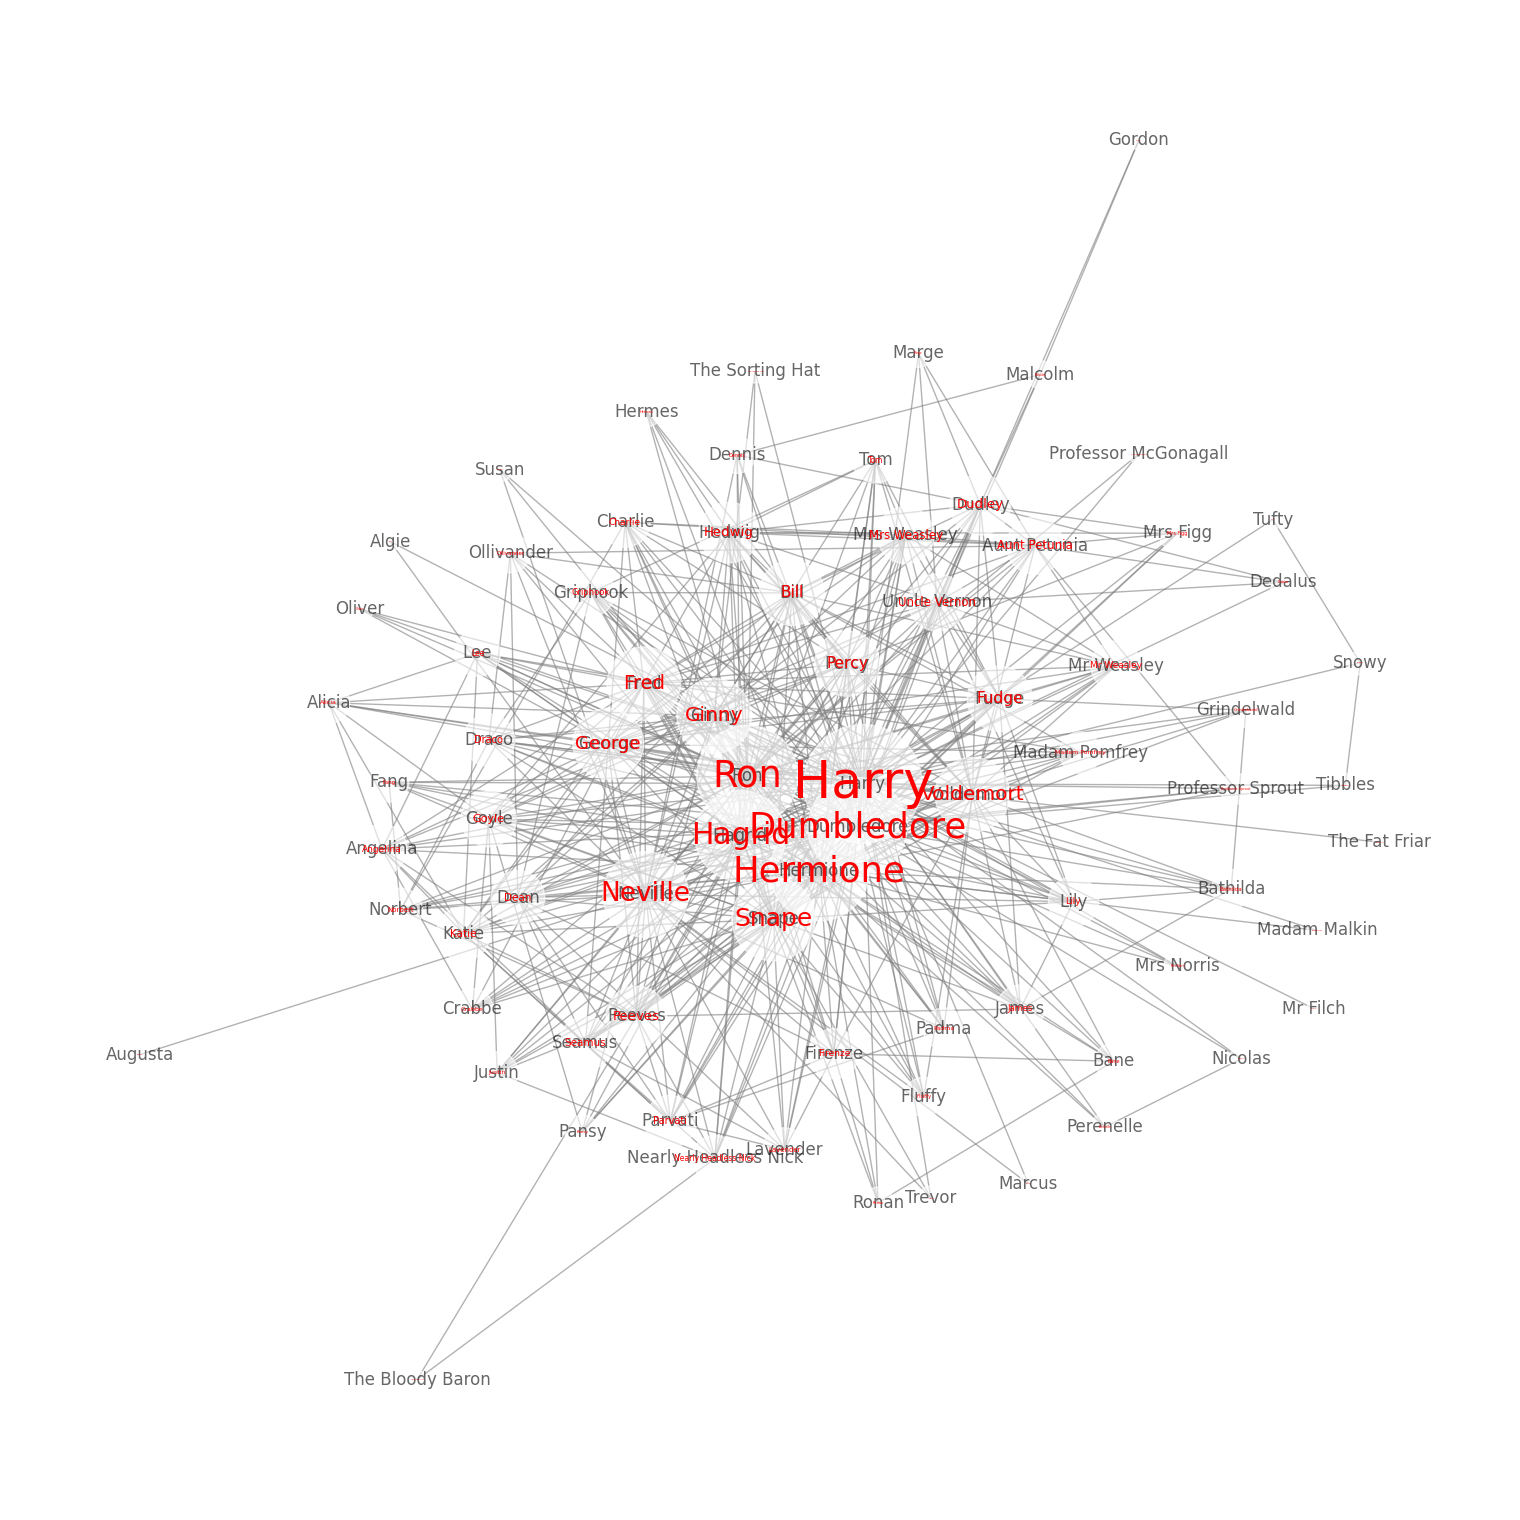

In [57]:
plt.figure(figsize=(15,15))
pos = nx.kamada_kawai_layout(G_widget)
d = dict(G_widget.degree)
nx.draw(G_widget, with_labels=True, node_color='white', edge_cmap=plt.cm.Blues, pos = pos, node_size =[d[k]*100 for k in d],edge_color='gray', alpha = 0.6)
for node, (x, y) in pos.items():
    text(x, y, node, fontsize=d[node]/2, ha='center', va='center', color = 'r')
plt.savefig('./images/social_network/widget_graph.png')
plt.show()

In [58]:
# Degree centrality
deg_cent_widget = nx.degree_centrality(G_widget)
deg_cent_widget = pd.DataFrame(deg_cent_widget.items(), columns=['character', 'deg_cent_widget'])
deg_cent_widget = deg_cent_widget.sort_values(by='deg_cent_widget', ascending=False).reset_index().drop('index', axis = 1)
deg_cent_widget.head(5)

character  deg_cent_widget
0       Harry         0.960526
1         Ron         0.697368
2  Dumbledore         0.671053
3    Hermione         0.671053
4      Hagrid         0.565789

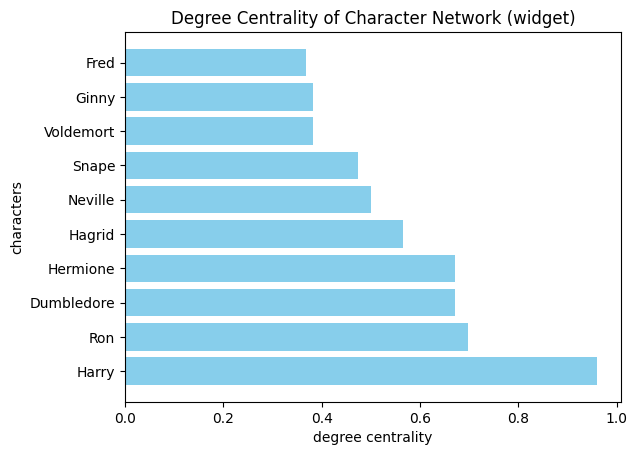

In [70]:
plt.barh(deg_cent_widget['character'][:10], deg_cent_widget['deg_cent_widget'][:10],color = "skyblue")
plt.xticks(ticks=[0, 0.2,0.4,0.6,0.8, 1])
plt.ylabel('characters')
plt.xlabel('degree centrality')
plt.title('Degree Centrality of Character Network (widget)')
plt.savefig('./images/social_network/widget_deg_cent.png')

In [71]:
page_rank_widget = nx.pagerank(G_widget)
page_rank_widget = pd.DataFrame(page_rank_widget.items(), columns=['character', 'page_rank'])
page_rank_widget = page_rank_widget.sort_values(by='page_rank', ascending=False)
page_rank_widget.head(5)

character  page_rank
1        Harry   0.073440
24         Ron   0.046271
31    Hermione   0.044218
2   Dumbledore   0.044049
6       Hagrid   0.036341

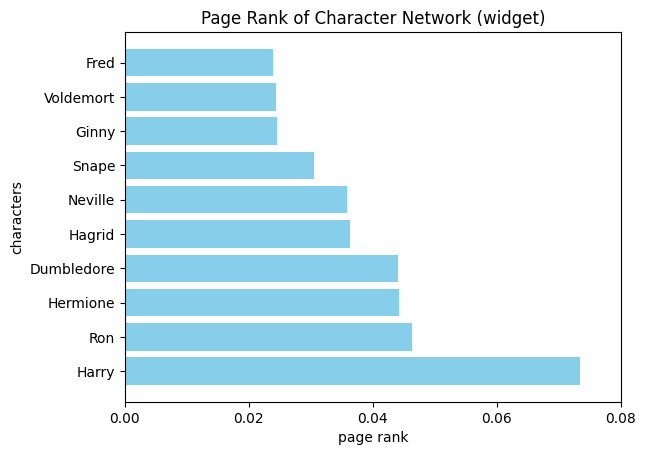

In [72]:
plt.barh(page_rank_widget['character'][:10], page_rank_widget['page_rank'][:10],color = "skyblue")
plt.xticks(ticks=[0,0.02,0.04, 0.06, 0.08])
plt.ylabel('characters')
plt.xlabel('page rank')
plt.title('Page Rank of Character Network (widget)')
plt.savefig('./images/social_network/widget_page_rank.png')

In [62]:
# get info about number of nodes and edges
nx.info(G_widget)

'Graph with 77 nodes and 523 edges'

#### Community Detection on Character Network

We will apply two community detection algorithm on the graph: Louvain and Girwan newman with the networkx package.

Start with Louvain Algorithm:

In [64]:
# community detection with louvain
communities_louvain = nx.community.louvain_communities(G_widget, seed=123)

In [65]:
modularity_louvain = nx.community.modularity(G_widget, communities_louvain, weight = 'value')
print(f' The modularity with the louvain community detection algorithm is: {modularity_louvain} ')

 The modularity with the louvain community detection algorithm is: -0.15036611658614912 


We will try to optimise the modularity in the following.

In [50]:
# we will try label_propagation_communities
modularity_lab_prog = nx.community.modularity(G_widget, nx.community.label_propagation_communities(G_widget))
print(f' The modularity with the Label propagation community detection algorithm is: {modularity_lab_prog}. ')

 The modularity with the Label propagation community detection algorithm is: 0.0. 


In [51]:
# optimization with naive greedy algorithm
communities_opt = nx.community.naive_greedy_modularity_communities(G_widget, weight = 'value')
modularity_opt = nx.community.modularity(G_widget, communities_opt)
print(f'The optimized modularity with the naive greedy algorithm is: {np.round(modularity_opt,2) }.')

The optimized modularity with the naive greedy algorithm is: 0.11321651451948422.


In [73]:
communities_louvain = community_louvain.best_partition(G_widget)

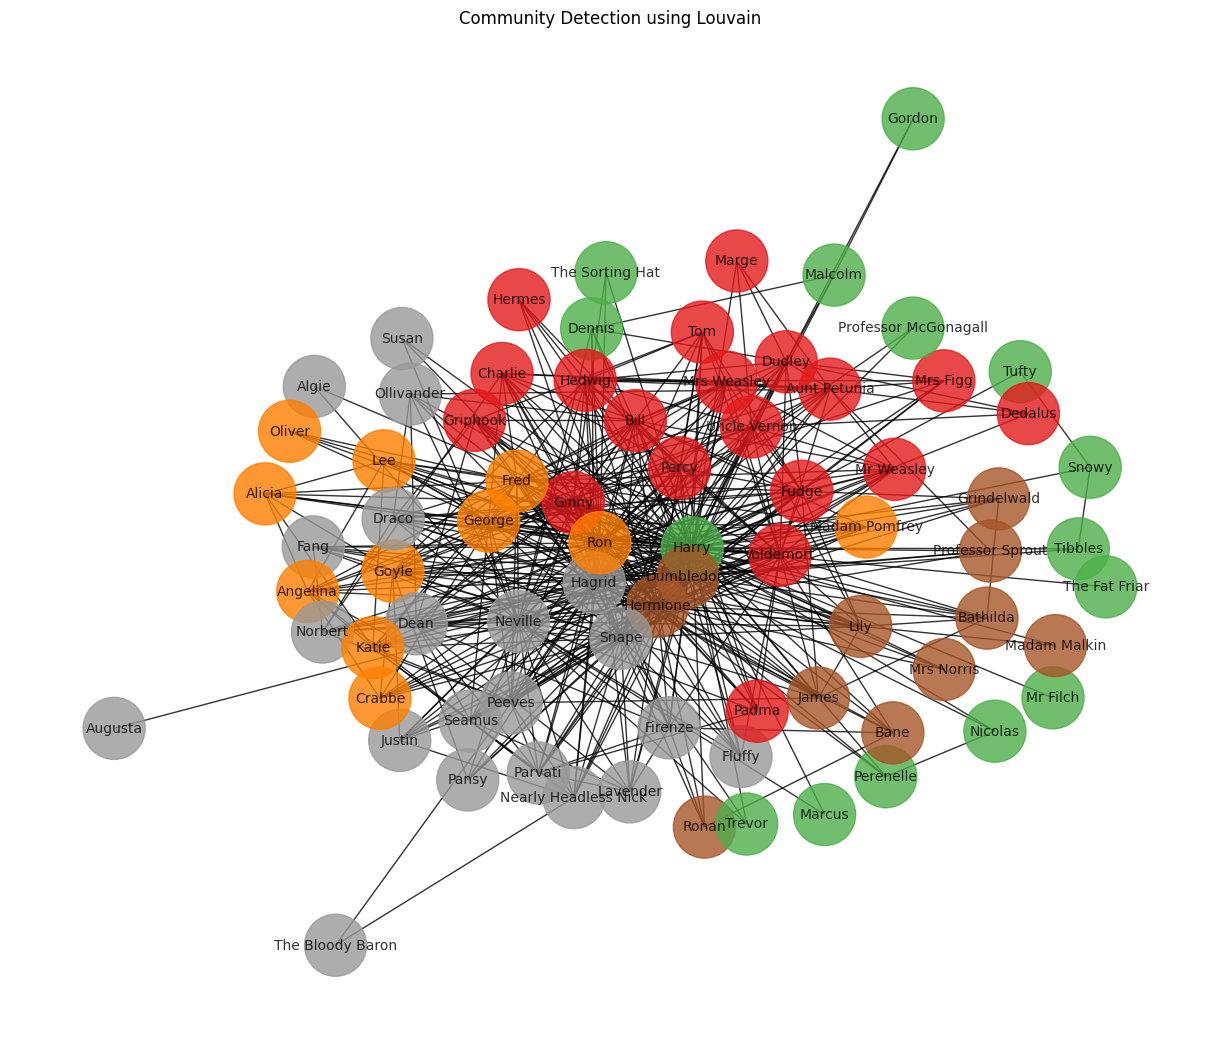

In [74]:
plt.figure(figsize=(12, 10))
nx.draw(G_widget, pos, with_labels=True, font_size=10, node_size=2000, node_color=np.array(list(communities_louvain.values())), cmap=plt.cm.Set1, alpha=0.8)
plt.title('Community Detection using Louvain')
plt.savefig('./images/social_network/cn_louvain.png')
plt.show()

Girwan Newman Algorithm:

In [75]:
communities_girv_new = nx.community.girvan_newman(G_widget)

In [76]:
communities = list(nx.community.girvan_newman(G_widget))

modularity_df = pd.DataFrame(
    [[k + 1, nx.community.modularity(G_widget, communities[k])]for k in range(len(communities))],columns=["k", "modularity"],
)

In [77]:
modularity_df.max()

k             76.000000
modularity     0.009306
dtype: float64

In [79]:
G_widget.edges.values

<bound method Mapping.values of EdgeView([('Dudley', 'Harry'), ('Dudley', 'Dumbledore'), ('Dudley', 'Uncle Vernon'), ('Dudley', 'Aunt Petunia'), ('Dudley', 'Dennis'), ('Dudley', 'Gordon'), ('Dudley', 'Marge'), ('Dudley', 'Hagrid'), ('Dudley', 'Ron'), ('Dudley', 'Voldemort'), ('Dudley', 'Hermione'), ('Dudley', 'Malcolm'), ('Dudley', 'Mrs Figg'), ('Dudley', 'Bill'), ('Dudley', 'Ginny'), ('Dudley', 'Fudge'), ('Dudley', 'Snape'), ('Dudley', 'Dedalus'), ('Dudley', 'Hedwig'), ('Harry', 'Dumbledore'), ('Harry', 'Voldemort'), ('Harry', 'Hagrid'), ('Harry', 'James'), ('Harry', 'Aunt Petunia'), ('Harry', 'Uncle Vernon'), ('Harry', 'Tibbles'), ('Harry', 'Tufty'), ('Harry', 'Marge'), ('Harry', 'Lily'), ('Harry', 'Snowy'), ('Harry', 'Griphook'), ('Harry', 'Ollivander'), ('Harry', 'Hedwig'), ('Harry', 'Ginny'), ('Harry', 'Percy'), ('Harry', 'Fred'), ('Harry', 'George'), ('Harry', 'Ron'), ('Harry', 'Lee'), ('Harry', 'Bill'), ('Harry', 'Neville'), ('Harry', 'The Sorting Hat'), ('Harry', 'Susan'), ('Ha

In [81]:
G_widget.add_edges_from(G_widget.edges)
if not nx.is_connected(G_widget):
    print('Graph is not fully connected') 
else:
    print('Graph is fully connected')

Graph is fully connected


In [ ]:

adj= nx.adjacency_matrix(G_widget).todense()
adj = pd.DataFrame(adj, index=G_widget.nodes(), columns=G_widget.nodes())

In [153]:
k = 100
clust = {}
for k in range(2, k+1):
    sc = SpectralClustering(n_clusters=k, affinity='precomputed', n_init=10,assign_labels='discretize')
    sc.fit(adj)
    clust[k] = pd.DataFrame(sc.labels_, index=G_widget.nodes(),columns=['cat']).reset_index(names=['node'])

In [154]:
mods = {}
for i in range(2, k+1):
    mods[i] = modularity(G_widget, clust[i].groupby('cat')['node'].apply(list).to_list())
    max_mod = max(mods.values())
    k_max = [i for i, v in mods.items() if v == max_mod][0]

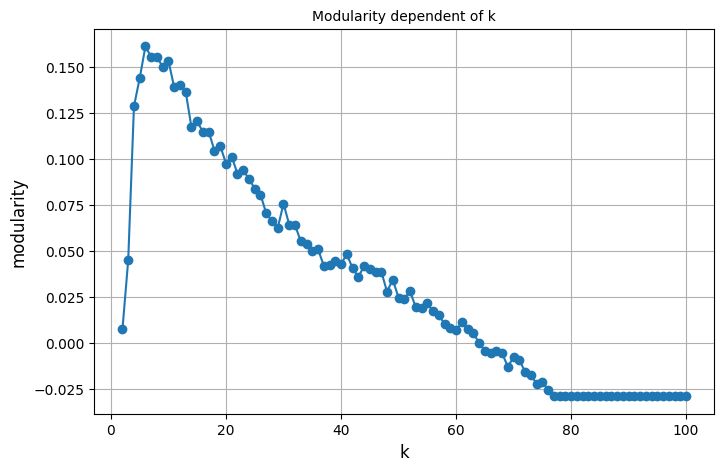

In [157]:

plt.figure(figsize=(8, 5))
plt.plot(mods.keys(), mods.values())
plt.title('Modularity dependent of k', fontsize=10)
plt.xlabel('k', fontsize=12)
plt.ylabel('modularity', fontsize=12)
plt.grid()
plt.show()

#### Graph Embedding:

Since the results related to modularity is quite low we will go on with Graph embedding.

Generating walks (CPU: 9): 100%|██████████| 20/20 [00:00<00:00, 32.57it/s]


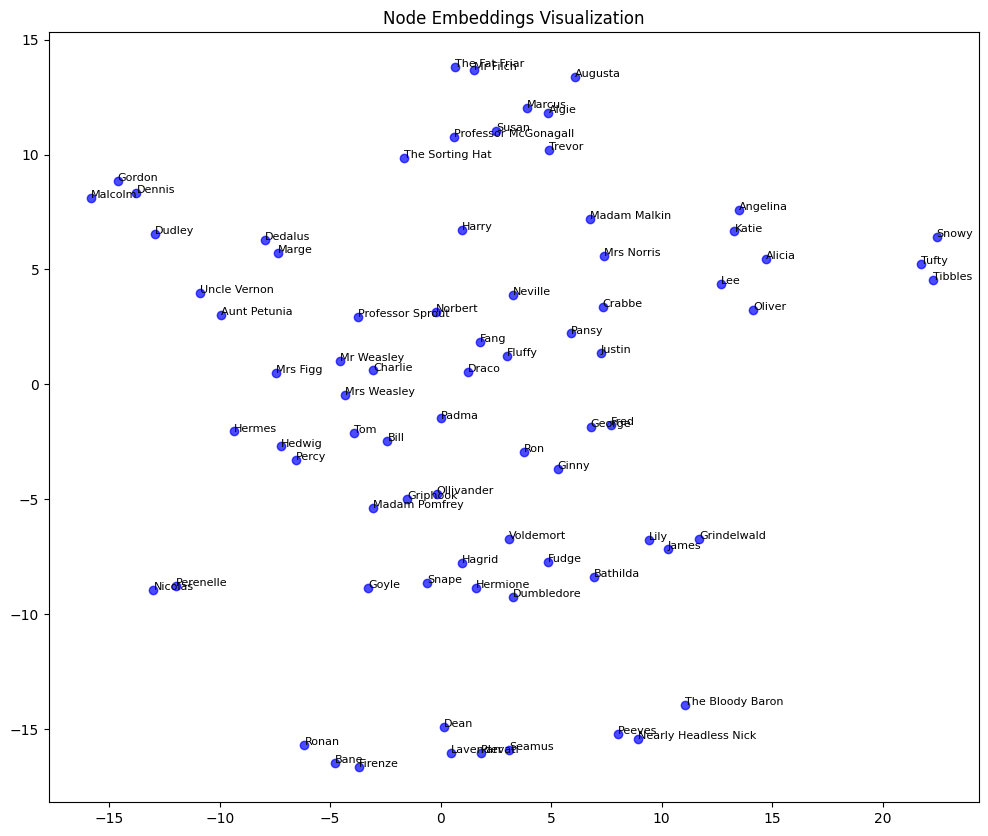

In [87]:
from sn_utils import *
model = word_embedding(G_widget, dim = 30, walk_length = 30, num_walks = 200, workers= 10)
embeddings_2d = embedding(model, G_widget, perplexity= 10, n_iter= 400)
# Visualize embeddings in 2D space with node labels
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)

# Add node labels
for i, node in enumerate(G_widget.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)

plt.title('Node Embeddings Visualization')
plt.show()

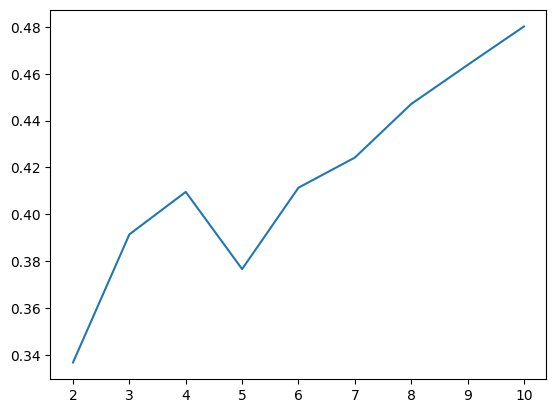

In [94]:
from sklearn.metrics import silhouette_score 
tsne_embedding = embeddings_2d 
s_list = []
for clus in range(2,11):
    km = KMeans(n_clusters = clus, n_init = 50, max_iter = 100) 
    km.fit(tsne_embedding)
    s = silhouette_score(tsne_embedding, km.labels_)
    s_list.append(s)
plt.plot(range(2,11), s_list)
plt.savefig('./images/social_network/cn_kmeans_sil_score.png')
plt.show()

In [90]:
cluster_labels = k_means_clustering(4, embeddings_2d)

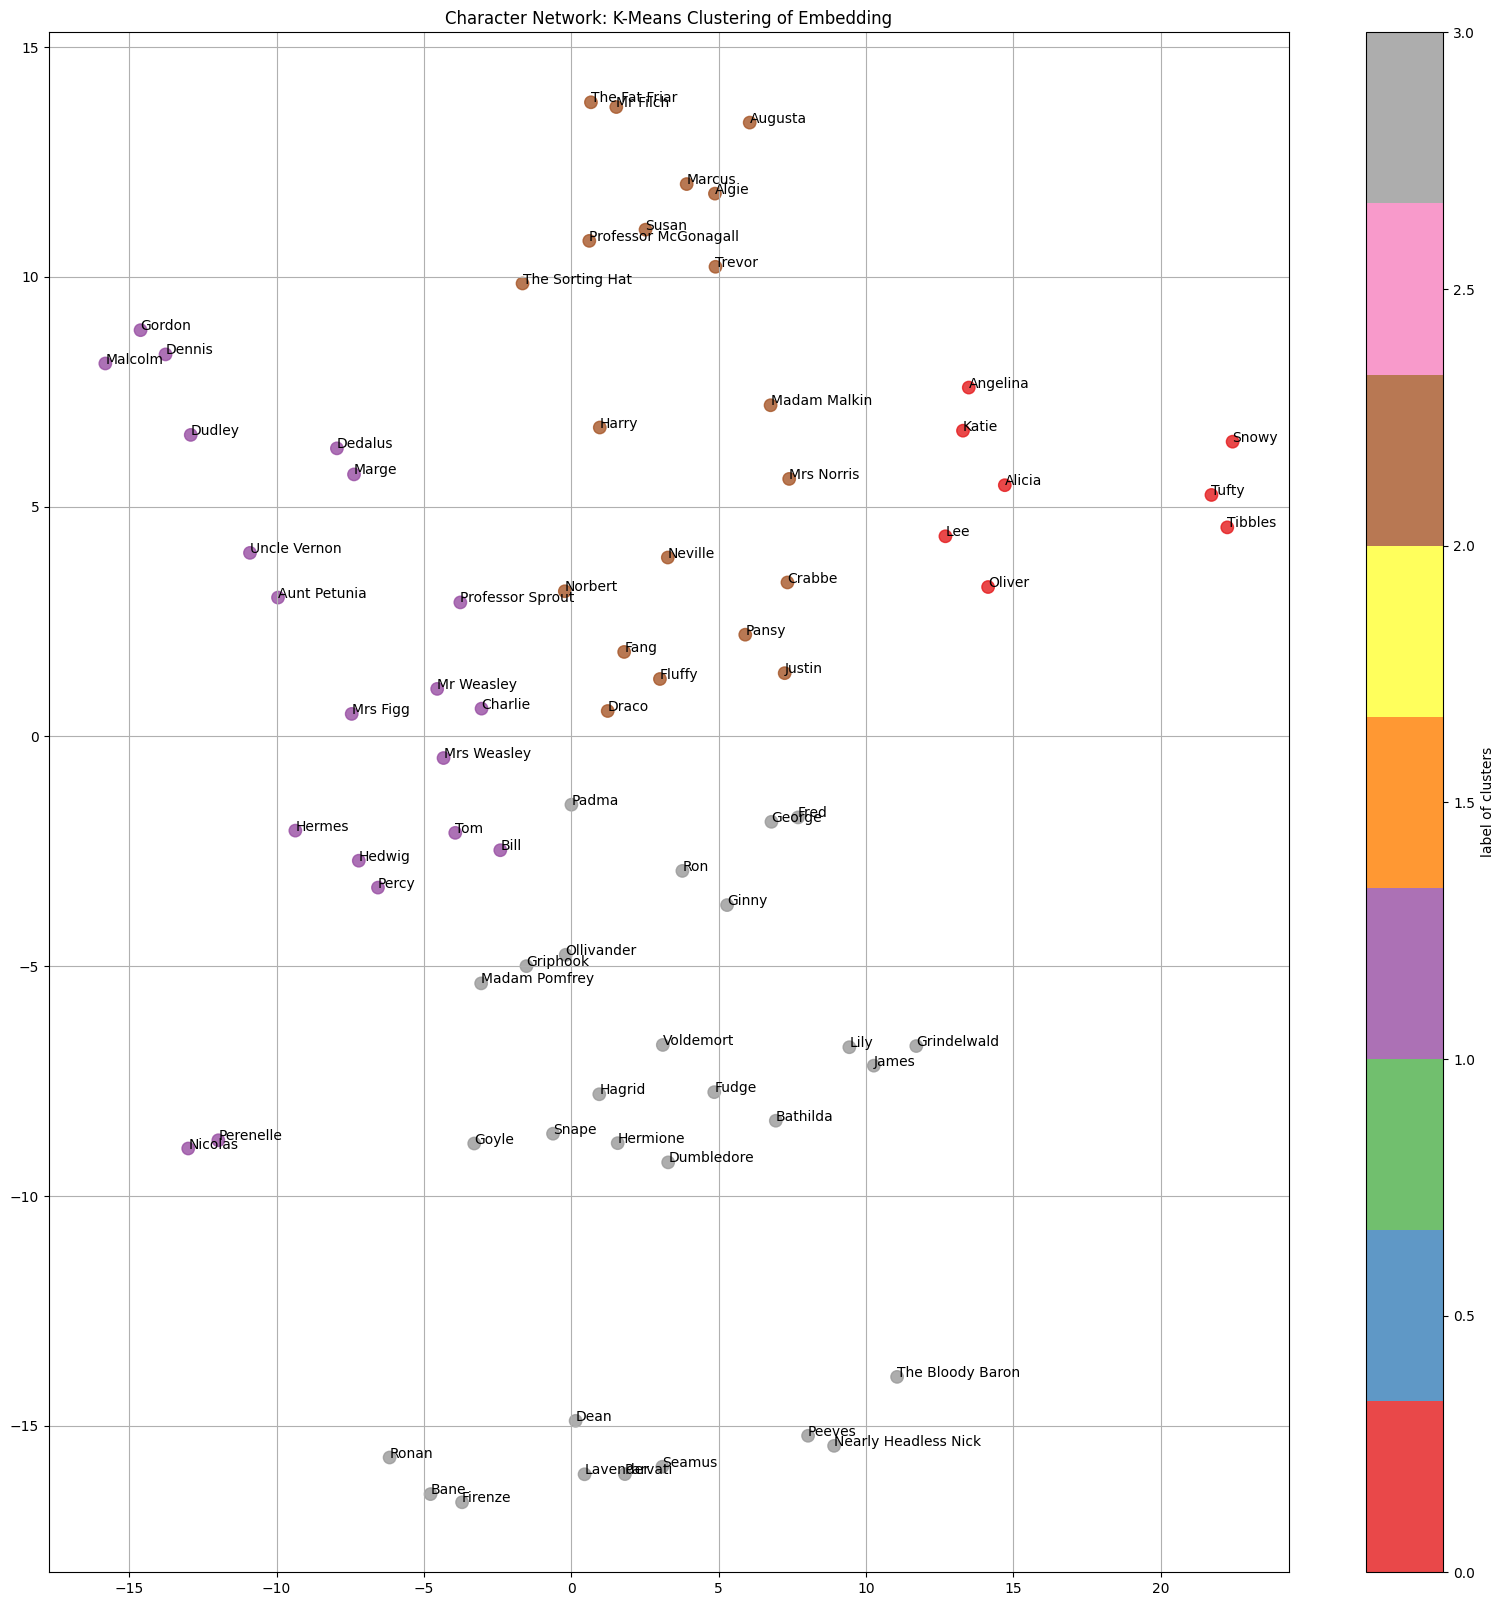

In [96]:
# Visualize K-Means clustering in the embedding space with node labels
plt.figure(figsize=(20, 20))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=plt.cm.Set1, alpha=0.8, s = 160)

# Add node labels
for i, node in enumerate(G_widget.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=10)

plt.title('Character Network: K-Means Clustering of Embedding')

plt.colorbar(label='label of clusters')
plt.grid('off')
plt.savefig('./images/social_network/cn_kmeans.png')
plt.show()

In [97]:
from sklearn.cluster import AgglomerativeClustering
hierarchical_function = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hierarchical_labels = hierarchical_function.fit_predict(embeddings_2d)

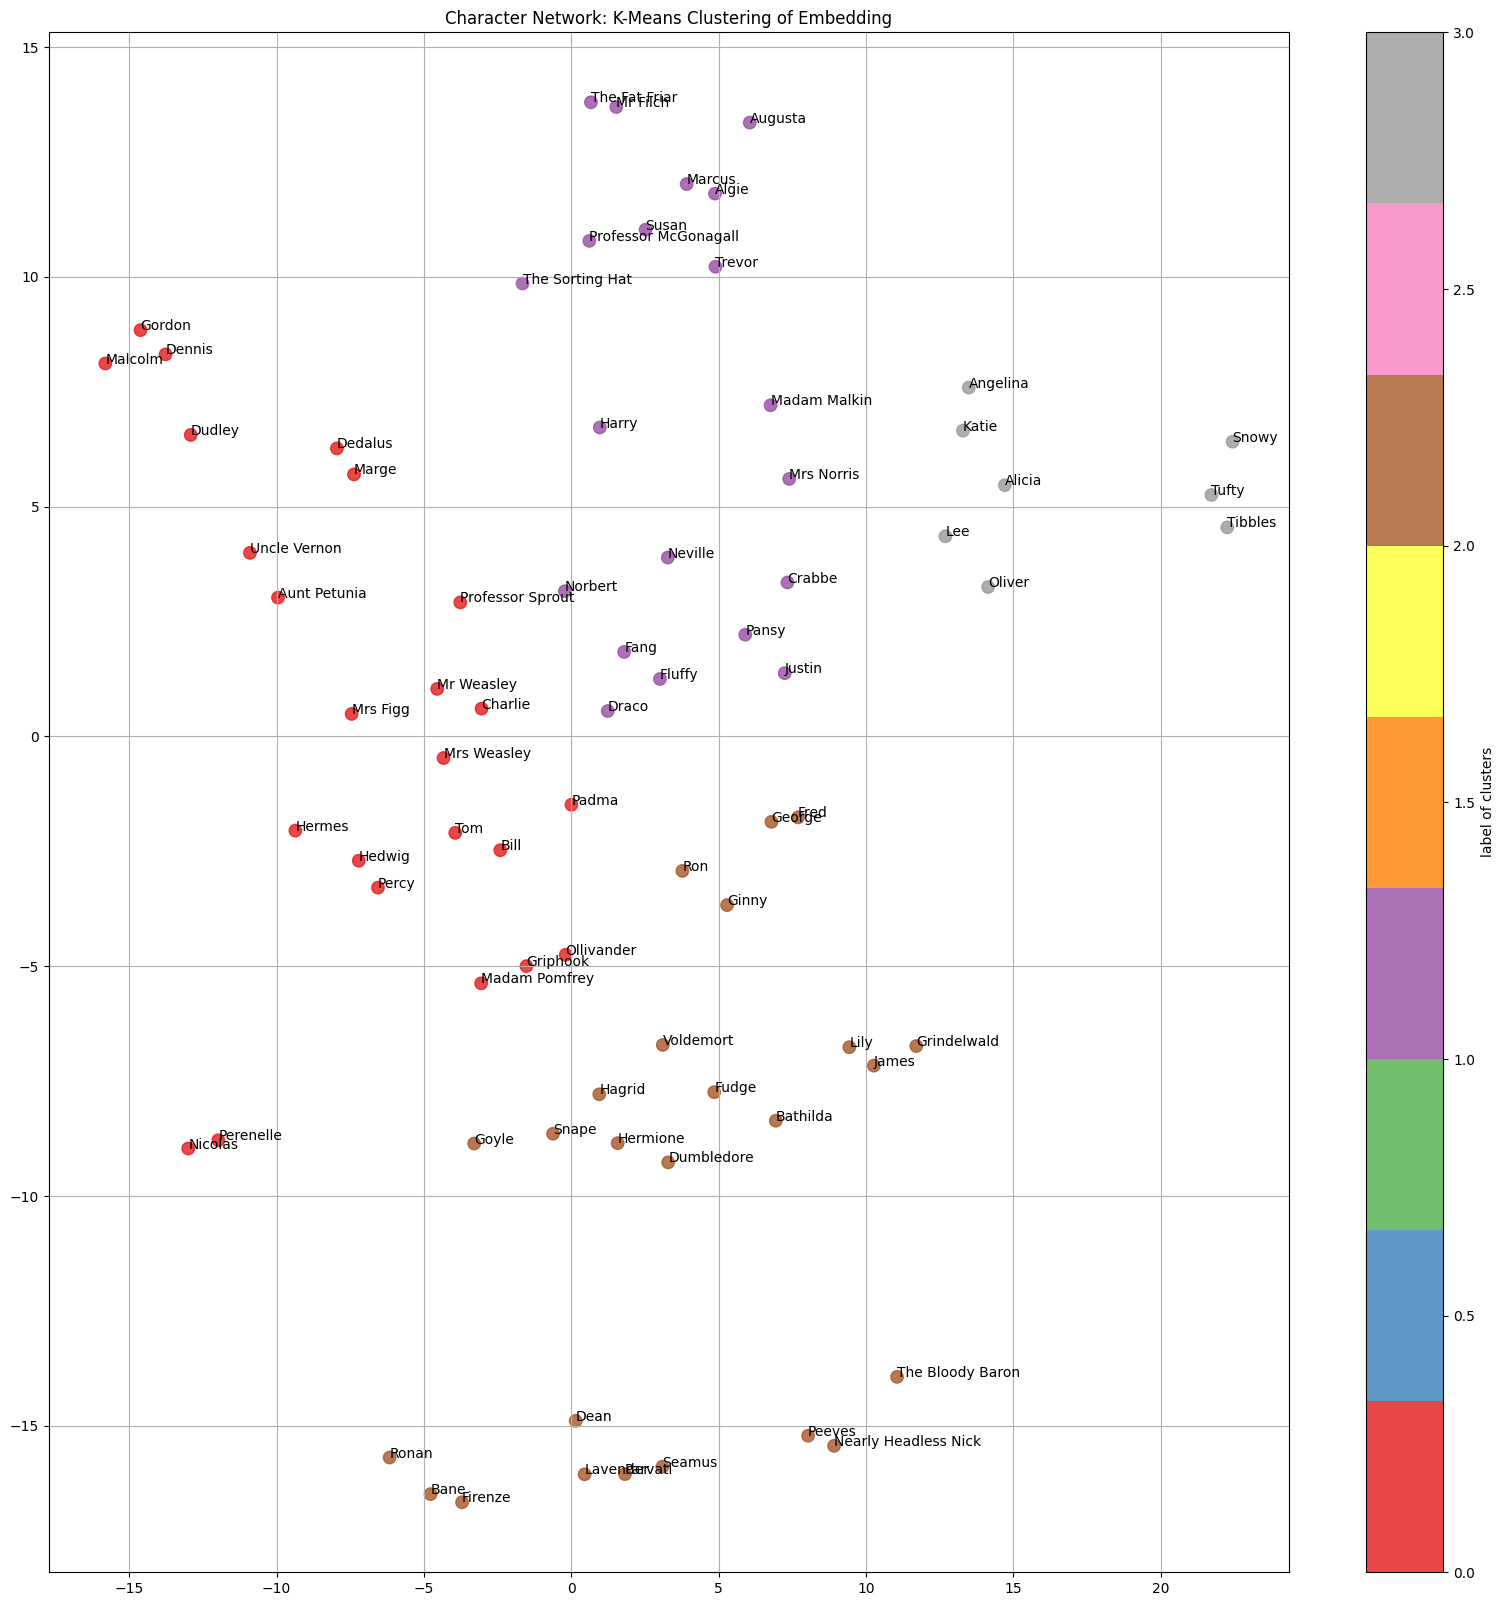

In [98]:
# Visualize K-Means clustering in the embedding space with node labels
plt.figure(figsize=(20, 20))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=hierarchical_labels, cmap=plt.cm.Set1, alpha=0.8, s = 80)

# Add node labels
for i, node in enumerate(G_widget.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=12)

plt.title('Character Network: Hierarchical Clustering of Embedding')

plt.colorbar(label='label of clusters')
plt.grid('off')
plt.savefig('./images/social_network/cn_kmeans.png')
plt.show()

### 3. Social Network with Sentiment Analysis <a class="anchor" id="sn"></a>

In this part we will build a social network on the basis of sentiment analysis, which we will compare with the results above in terms of community detection and Graph embedding.


In [99]:
# apply sentiment analysis on the filtered sentences in which appear characters from character_df
analyzer = SentimentIntensityAnalyzer()
compound = [analyzer.polarity_scores(str(x))['compound'] for x in sent_entity_df_filtered['sentence']]

In [100]:
# define dataframe wit compound value
sentiment_df = pd.DataFrame({'compound': pd.Series(compound), 'characters': pd.Series(sent_entity_df_filtered['character_entities']).reset_index()['character_entities']})
sentiment_df.head(3)

compound characters
0   -0.2960   [Dudley]
1    0.6343   [Dudley]
2   -0.4005   [Dudley]

In [101]:
# take the string and not the list of the characters
characters = []
for i in range(len(sentiment_df)):
    characters.append(sentiment_df['characters'][i][0])

In [102]:
sentiment_df['characters_string'] = pd.Series(characters)
sentiment_df = sentiment_df.drop('characters', axis=1)
sentiment_df.head(3)

compound characters_string
0   -0.2960            Dudley
1    0.6343            Dudley
2   -0.4005            Dudley

In [103]:
sentiment_df = sentiment_df.groupby('characters_string').sum()
sentiment_df = sentiment_df.reset_index()
sentiment_df.head()

characters_string  compound
0             Algie    0.8334
1            Alicia   -1.1770
2          Angelina    2.5595
3           Augusta    0.8491
4      Aunt Petunia   -9.7018

In [107]:
sentiments_source = []
for i in range(len(relationship_df)):
    sentiments_source.append(np.array(sentiment_df[sentiment_df['characters_string'] == relationship_df['source'][i]].compound))

sentiments_target = []
for i in range(len(relationship_df)):
    sentiments_targ = np.array(sentiment_df[sentiment_df['characters_string'] == relationship_df['target'][i]].compound)
    sentiments_target.append(sentiments_targ)

In [108]:
relationship_df['sentiments_target'] = pd.Series(sentiments_target)
relationship_df['sentiments_source'] = pd.Series(sentiments_source)
relationship_df

source           target  value      sentiments_target  \
0             Dudley            Harry   1053             [172.2837]   
1              Harry           Dudley   1006              [-12.689]   
2             Dudley       Dumbledore     38             [123.4876]   
3         Dumbledore        Voldemort    802             [-58.9032]   
4          Voldemort       Dumbledore    656             [123.4876]   
..               ...              ...    ...                    ...   
868            Ginny             Lily      5  [0.49540000000000023]   
869            Ginny            James     11                [4.993]   
870           Peeves            James      5                [4.993]   
871            Ginny  The Sorting Hat      5                  [0.0]   
872  The Sorting Hat            Harry      6             [172.2837]   

        sentiments_source  
0               [-12.689]  
1              [172.2837]  
2               [-12.689]  
3              [123.4876]  
4              [-58.9032]  
..                    ...  
868  [35.419200000000004]  
869  [35.419200000000004]  
870             [-5.3178]  
871  [35.419200000000004]  
872                 [0.0]  

[873 rows x 5 columns]

In [104]:
names = []
for i in range(len(character_df)):
    names.append(character_df['Name'][i].lower())

In [105]:
# get most occurent clean words from data
all_clean_words = df['clean_words'].to_list()
all_clean_words = np.concatenate(all_clean_words)
count_dict = Counter(all_clean_words)
all_clean_words_count = pd.DataFrame(count_dict.items()).rename(columns={0:'word',1:'count'})

In [106]:
# counts the number each name of character appears in clean_words
names_count = all_clean_words_count[all_clean_words_count["word"].isin(names)]
names_count = names_count.reset_index().drop('index', axis =1)
names_count.head()

word  count
0      dudley    348
1       harry  15979
2  dumbledore   2805
3     dedalus     21
4   voldemort    947

In [109]:
# sources and target to lower for better comparison
sources = []
targets = []
for i in range(len(relationship_df)):
    sources.append(relationship_df['source'][i].lower())
    targets.append(relationship_df['target'][i].lower())

In [110]:
rel_sent_data = pd.DataFrame({'source': pd.Series(sources), 'target': pd.Series(targets), 'sentiments_source': pd.Series(np.concatenate(relationship_df['sentiments_source']).ravel()), 'sentiments_target': pd.Series(np.concatenate(relationship_df['sentiments_target']).ravel())})
rel_sent_data.head(3)

source      target  sentiments_source  sentiments_target
0  dudley       harry           -12.6890           172.2837
1   harry      dudley           172.2837           -12.6890
2  dudley  dumbledore           -12.6890           123.4876

In [111]:
# get occurency of source and target form names_count
occurence_source = []
for i in range(len(rel_sent_data)):
    occurence_source.append(np.array(names_count[names_count['word'] == rel_sent_data['source'][i]]['count']))

occurence_target = []
for i in range(len(rel_sent_data)):
    occurence_target.append(np.array(names_count[names_count['word'] == rel_sent_data['target'][i]]['count']))

In [112]:
rel_sent_data['occurence_source'] = pd.Series(occurence_source)
rel_sent_data['occurence_target'] = pd.Series(occurence_target)
rel_sent_data.head(5)

source      target  sentiments_source  sentiments_target  \
0      dudley       harry           -12.6890           172.2837   
1       harry      dudley           172.2837           -12.6890   
2      dudley  dumbledore           -12.6890           123.4876   
3  dumbledore   voldemort           123.4876           -58.9032   
4   voldemort  dumbledore           -58.9032           123.4876   

  occurence_source occurence_target  
0            [348]          [15979]  
1          [15979]            [348]  
2            [348]           [2805]  
3           [2805]            [947]  
4            [947]           [2805]

In [113]:
# get normalized sentiment value of the relatioin by dividng the compound value of source and target through their number of occurence
sent_values = []
for i in range(len(rel_sent_data)):
    source_sent = rel_sent_data['sentiments_source'][i]
    source_occ = rel_sent_data['occurence_source'][i]
    target_sent = rel_sent_data['sentiments_target'][i]
    target_occ = rel_sent_data['occurence_target'][i]
    sent_values.append(source_sent/source_occ + target_sent/target_occ)

In [114]:
# get relation sentiments data with sent_values (sentiment/compound score of relationship between source and target)
rel_sent_data['sent_values'] = pd.Series(np.concatenate(sent_values).ravel())
rel_sent_data = rel_sent_data.drop(columns=['sentiments_source','sentiments_target','occurence_source','occurence_target'])
rel_sent_data.head(5)

source      target  sent_values
0      dudley       harry    -0.025681
1       harry      dudley    -0.025681
2      dudley  dumbledore     0.007561
3  dumbledore   voldemort    -0.018176
4   voldemort  dumbledore    -0.018176

In [115]:
# define who is friend and who is enemy
friend_enemy = []
for i in range(len(rel_sent_data)):
    if rel_sent_data['sent_values'][i]>=0.05:
        friend_enemy.append('friend')
    elif rel_sent_data['sent_values'][i]<=-0.05:
        friend_enemy.append('enemy')
    else:
        friend_enemy.append('object')

In [116]:
# add this to the dataframe
rel_sent_data['friend_enemy'] = pd.Series(friend_enemy)
rel_sent_data.head(3)

source      target  sent_values friend_enemy
0  dudley       harry    -0.025681       object
1   harry      dudley    -0.025681       object
2  dudley  dumbledore     0.007561       object

In [117]:
# count the number of unique enemy, friends, object (neutral) per column
rel_sent_data.groupby('friend_enemy').nunique()

source  target  sent_values
friend_enemy                             
enemy             45      41          100
friend            62      65          388
object            69      65          215

In [63]:
# get enemies and friends
enemies = rel_sent_data[rel_sent_data['friend_enemy'] == 'enemy']
friends = rel_sent_data[rel_sent_data['friend_enemy'] == 'friend']

In [119]:
# get relation to harry
rel_harry = rel_sent_data[(rel_sent_data['source'] == 'harry') | (rel_sent_data['target'] == 'harry')]
print(rel_harry.head(5))
print(f' Almost every character of the 77 has a relationship to harry since the length of the dataframe is: {len(rel_harry)}')

        source      target  sent_values friend_enemy
0       dudley       harry    -0.025681       object
1        harry      dudley    -0.025681       object
9   dumbledore       harry     0.054806       friend
10       harry   voldemort    -0.051418        enemy
11       harry  dumbledore     0.054806       friend
 Almost every character of the 77 has a relationship to harry since the length of the dataframe is: 135


In [120]:
# create graph from rel_harry
G_sent_harry = nx.from_pandas_edgelist(rel_harry, source = "source", target = "target", edge_attr = "friend_enemy", create_using = nx.Graph())

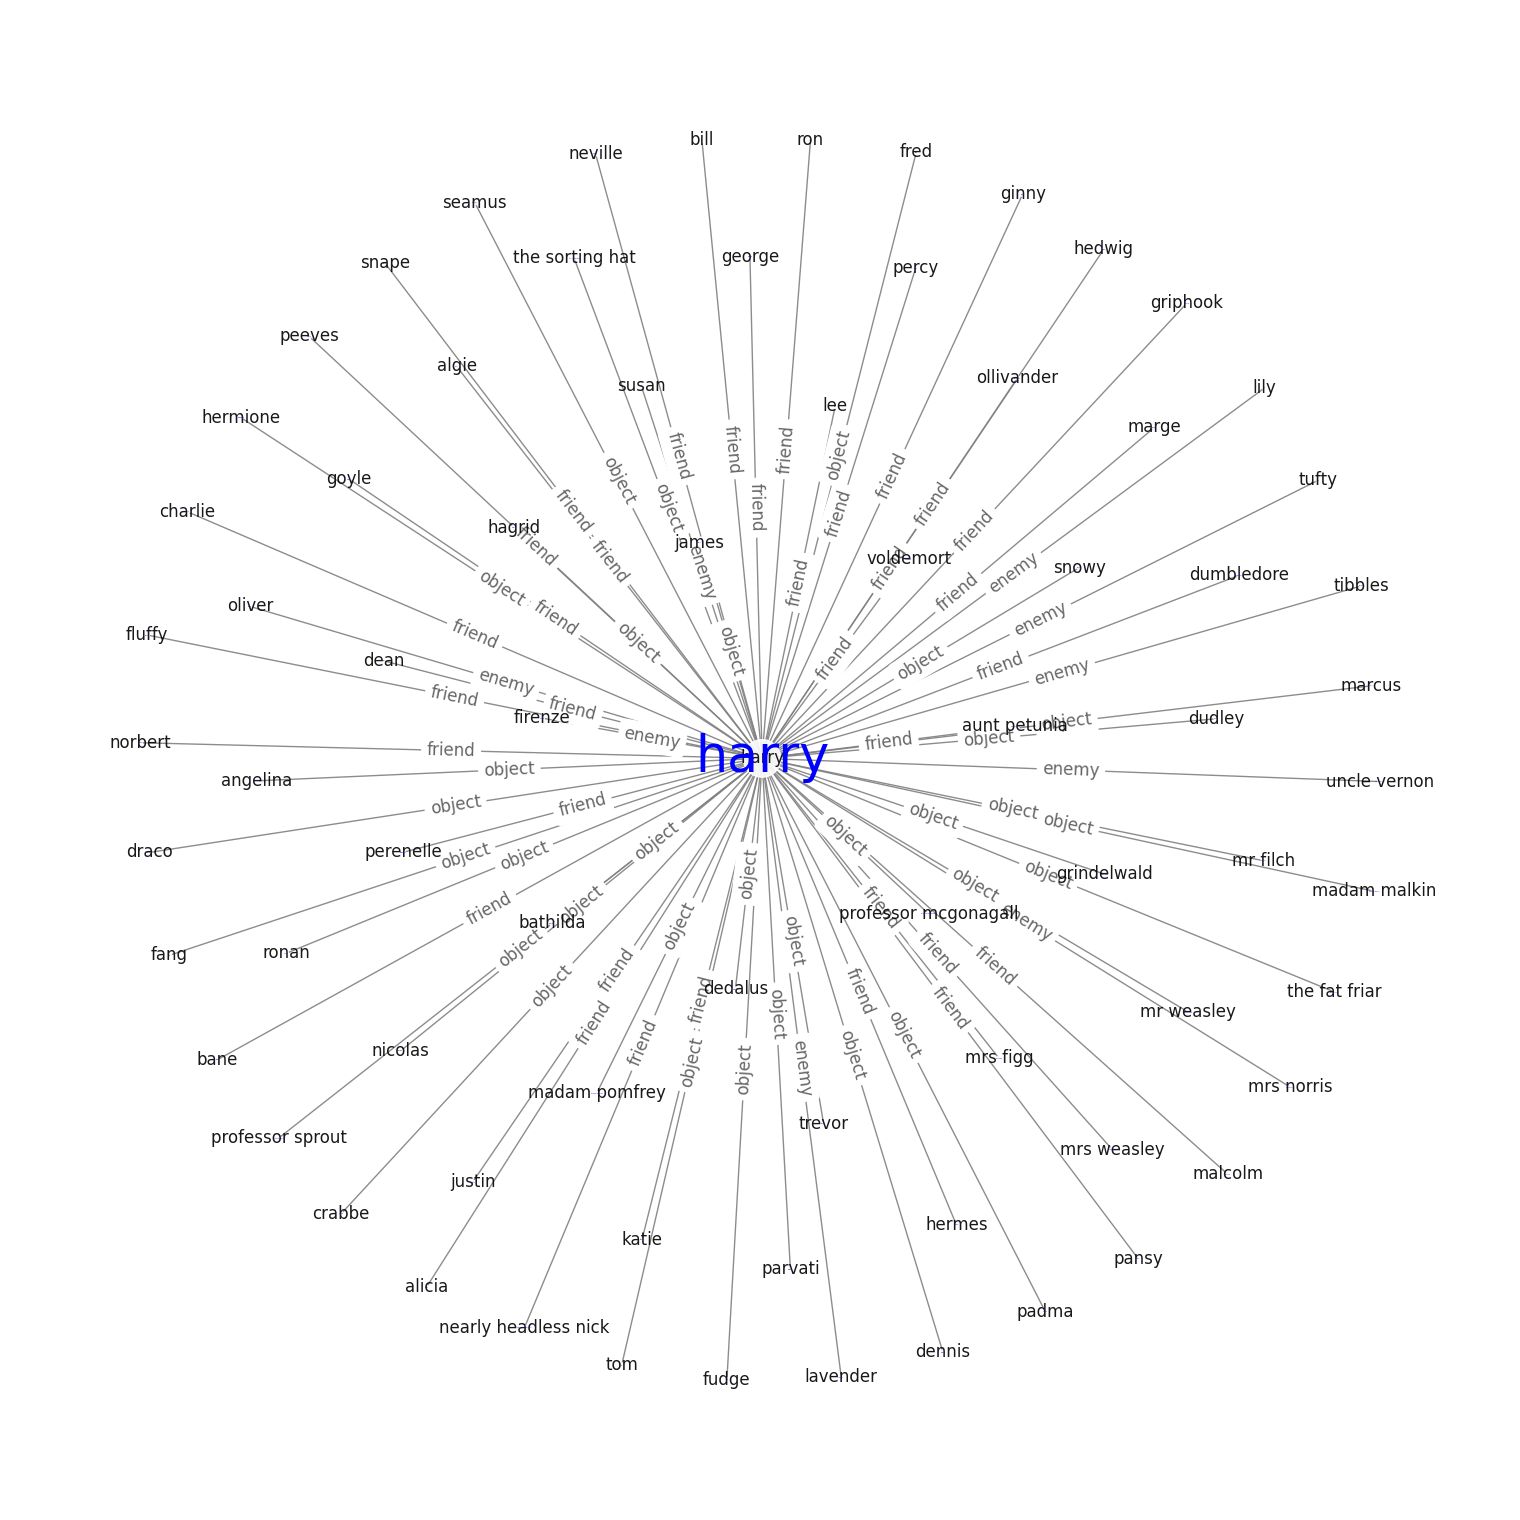

In [121]:
# plot graph with harry as source or target 
plt.figure(figsize=(15,15))
labels = nx.get_edge_attributes(G_sent_harry, 'friend_enemy')
pos = nx.kamada_kawai_layout(G_sent_harry)
d = dict(G_sent_harry.degree)
nx.draw(G_sent_harry, with_labels=True, node_color='white', edge_cmap=plt.cm.Blues, pos = pos, node_size =[d[k]*10 for k in d],edge_color='gray', alpha = 0.9)
for node, (x, y) in pos.items():
    text(x, y, node, fontsize=d[node]/2, ha='center', va='center', color = 'b')
nx.draw_networkx_edge_labels(G_sent_harry, pos=pos, label_pos=0.5, edge_labels=labels,font_size=12, font_color='black', alpha=0.6)
plt.savefig('./images/social_network/sent_deg_harry.png')
plt.show()

In [122]:
# create graph from rel_sent_data (all relations)
G_sent = nx.from_pandas_edgelist(rel_sent_data, source = "source", target = "target", edge_attr = "friend_enemy", create_using = nx.Graph())

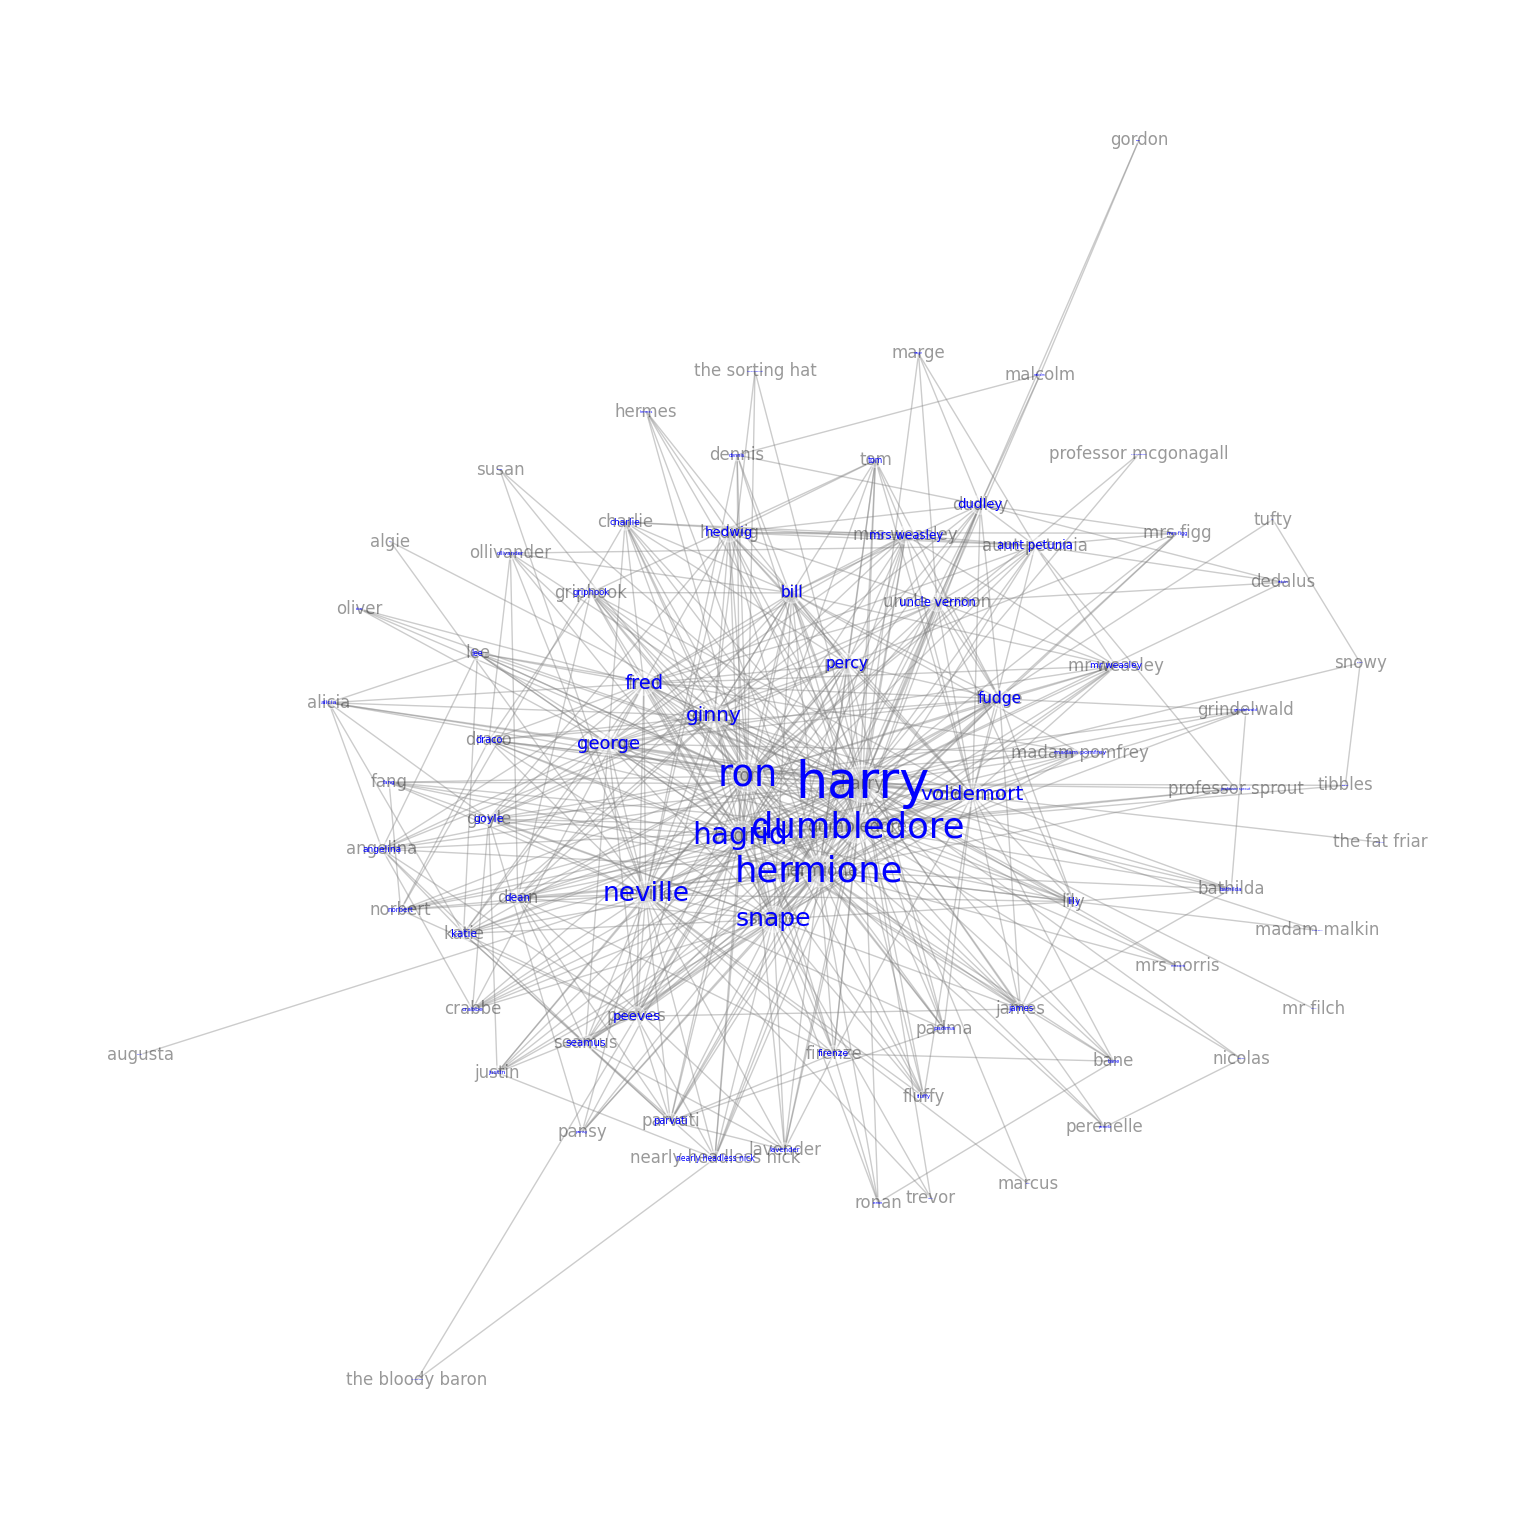

In [123]:
# plot G_sent
plt.figure(figsize=(15,15))
labels = nx.get_edge_attributes(G_sent, 'friend_enemy')
pos = nx.kamada_kawai_layout(G_sent)
d = dict(G_sent.degree)
nx.draw(G_sent, with_labels=True, node_color='white', edge_cmap=plt.cm.Blues, pos = pos, node_size =[d[k]*10 for k in d],edge_color='gray', alpha = 0.4)
for node, (x, y) in pos.items():
    text(x, y, node, fontsize=d[node]/2, ha='center', va='center', color = 'b')
#nx.draw_networkx_edge_labels(G_sent, pos=pos, label_pos=0.5, edge_labels=labels,font_size=12, font_color='black', alpha=0.6)
plt.savefig('./images/social_network/sent_graph.png')
plt.show()

In [124]:
# get pagerank
page_rank_sent = nx.pagerank(G_sent)
page_rank_sent = pd.DataFrame(page_rank_sent.items(), columns=['character', 'page_rank'])
page_rank_sent = page_rank_sent.sort_values(by='page_rank', ascending=False)
page_rank_sent.head(10)

character  page_rank
1        harry   0.073440
24         ron   0.046271
31    hermione   0.044218
2   dumbledore   0.044049
6       hagrid   0.036341
29     neville   0.035771
36       snape   0.030436
20       ginny   0.024579
3    voldemort   0.024446
22        fred   0.023888

In [126]:
# Degree centrality
deg_cent_sent = nx.degree_centrality(G_sent)
deg_cent_sent = pd.DataFrame(deg_cent_sent.items(), columns=['character', 'deg_cent_sent'])
deg_cent_sent = deg_cent_sent.sort_values(by='deg_cent_sent', ascending=False).reset_index().drop('index', axis = 1)
deg_cent_sent.head(10)

character  deg_cent_sent
0       harry       0.960526
1         ron       0.697368
2  dumbledore       0.671053
3    hermione       0.671053
4      hagrid       0.565789
5     neville       0.500000
6       snape       0.473684
7   voldemort       0.381579
8       ginny       0.381579
9        fred       0.368421

#### Community Detection on Social Network

In [170]:
# we will try label_propagation_communities
modularity_lab_prog = nx.community.modularity(G_sent, nx.community.label_propagation_communities(G_sent))
print(f' The modularity with the Label propagation community detection algorithm is: {modularity_lab_prog}. ')

 The modularity with the Label propagation community detection algorithm is: 0.0. 


In [171]:
# optimization with naive greedy algorithm
communities_opt = nx.community.naive_greedy_modularity_communities(G_sent, weight = 'value')
modularity_opt = nx.community.modularity(G_sent, communities_opt)
print(f'The optimized modularity with the naive greedy algorithm is: {np.round(modularity_opt,2) }.')

The optimized modularity with the naive greedy algorithm is: 0.17.


Generating walks (CPU: 10): 100%|██████████| 20/20 [00:00<00:00, 32.37it/s]


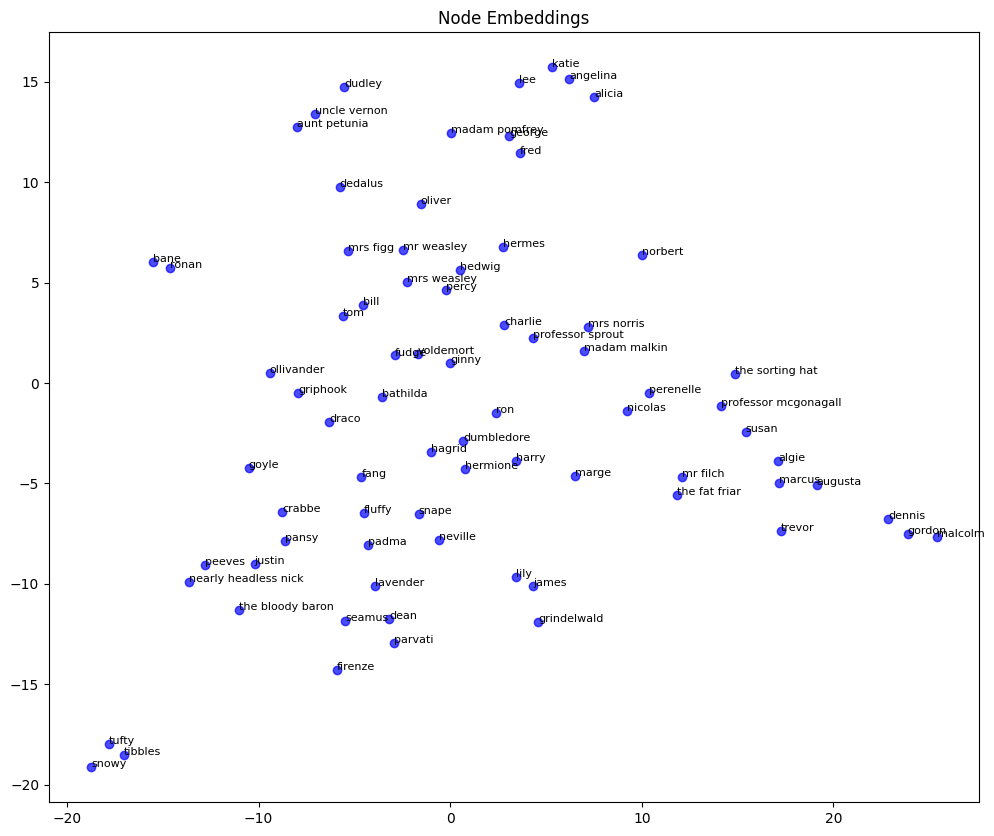

In [158]:
model = word_embedding(G_sent, dim = 40, walk_length = 30, num_walks = 200, workers= 10)
embeddings_2d = embedding(model, G_sent, perplexity= 10, n_iter= 400)
# embeddings 
plt.figure(figsize=(12, 10))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='blue', alpha=0.7)

# add node labels
for i, node in enumerate(G_sent.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=8)

plt.title('Node Embeddings')
plt.show()

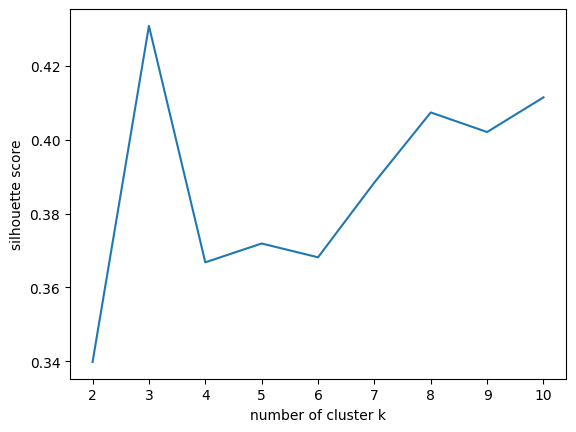

In [167]:
tsne_embedding = embeddings_2d 
# calculate silhouette score
s_list = []
for clus in range(2,11):
    km = KMeans(n_clusters = clus, n_init = 20, max_iter = 100) 
    km.fit(tsne_embedding)
    s = silhouette_score(tsne_embedding, km.labels_)
    s_list.append(s)
plt.plot(range(2,11), s_list)
plt.savefig('./images/social_network/sn_kmeans_sil_score.png')
plt.ylabel('silhouette score')
plt.xlabel('number of cluster k')
plt.show()

In [160]:
cluster_labels = k_means_clustering(3, embeddings_2d)

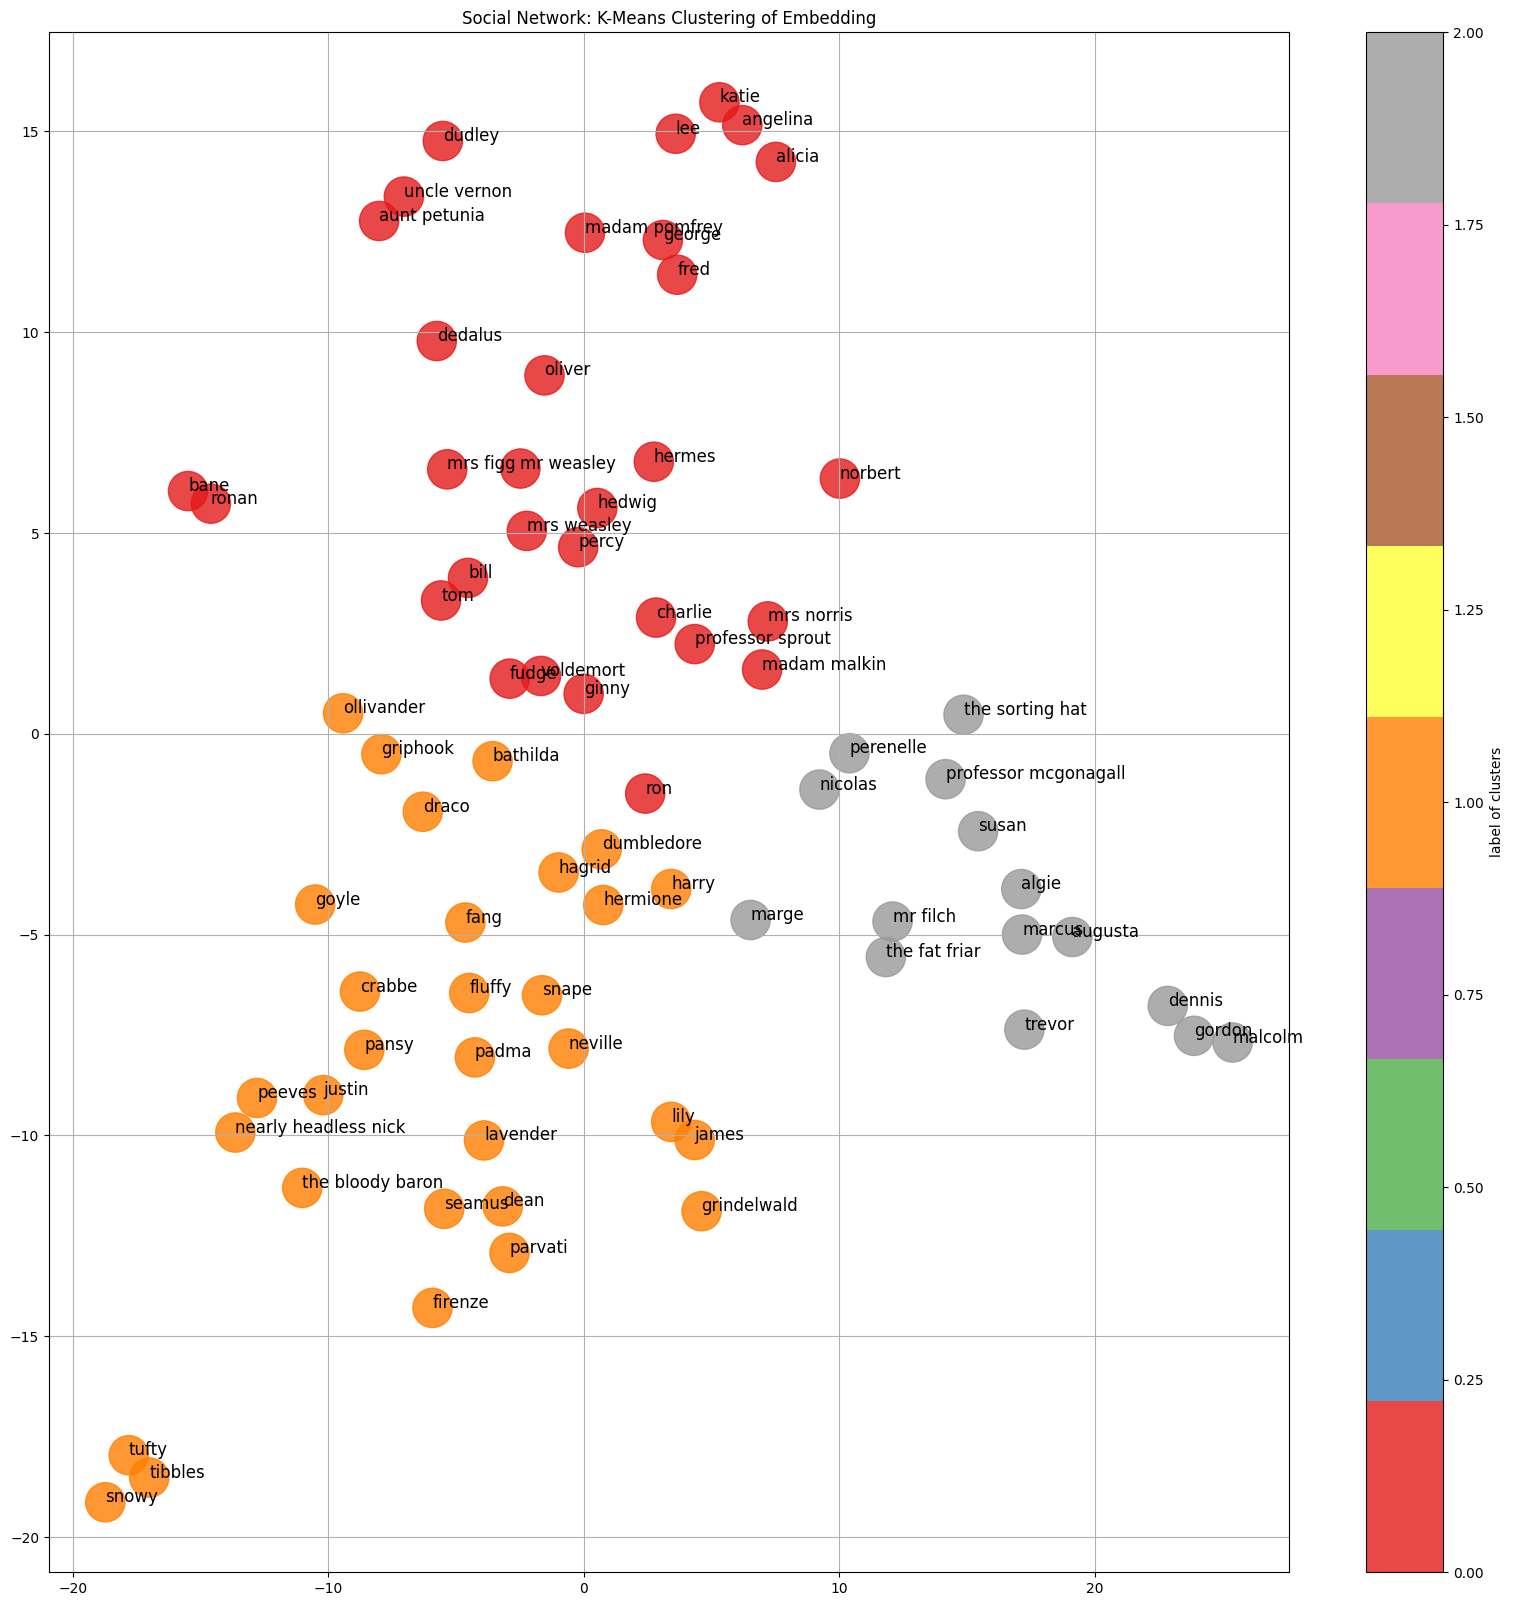

In [175]:
# Visualize K-Means clustering in the embedding space with node labels
plt.figure(figsize=(20, 20))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap=plt.cm.Set1, alpha=0.8, s = 800)

# Add node labels
for i, node in enumerate(G_sent.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=12)

plt.title('Social Network: K-Means Clustering of Embedding')

plt.colorbar(label='label of clusters')
plt.grid('off')
plt.savefig('./images/social_network/sn_kmeans.png')
plt.show()

In [164]:
hierarchical_function = AgglomerativeClustering(n_clusters = 4, affinity = 'euclidean', linkage = 'ward')
hierarchical_labels = hierarchical_function.fit_predict(embeddings_2d)

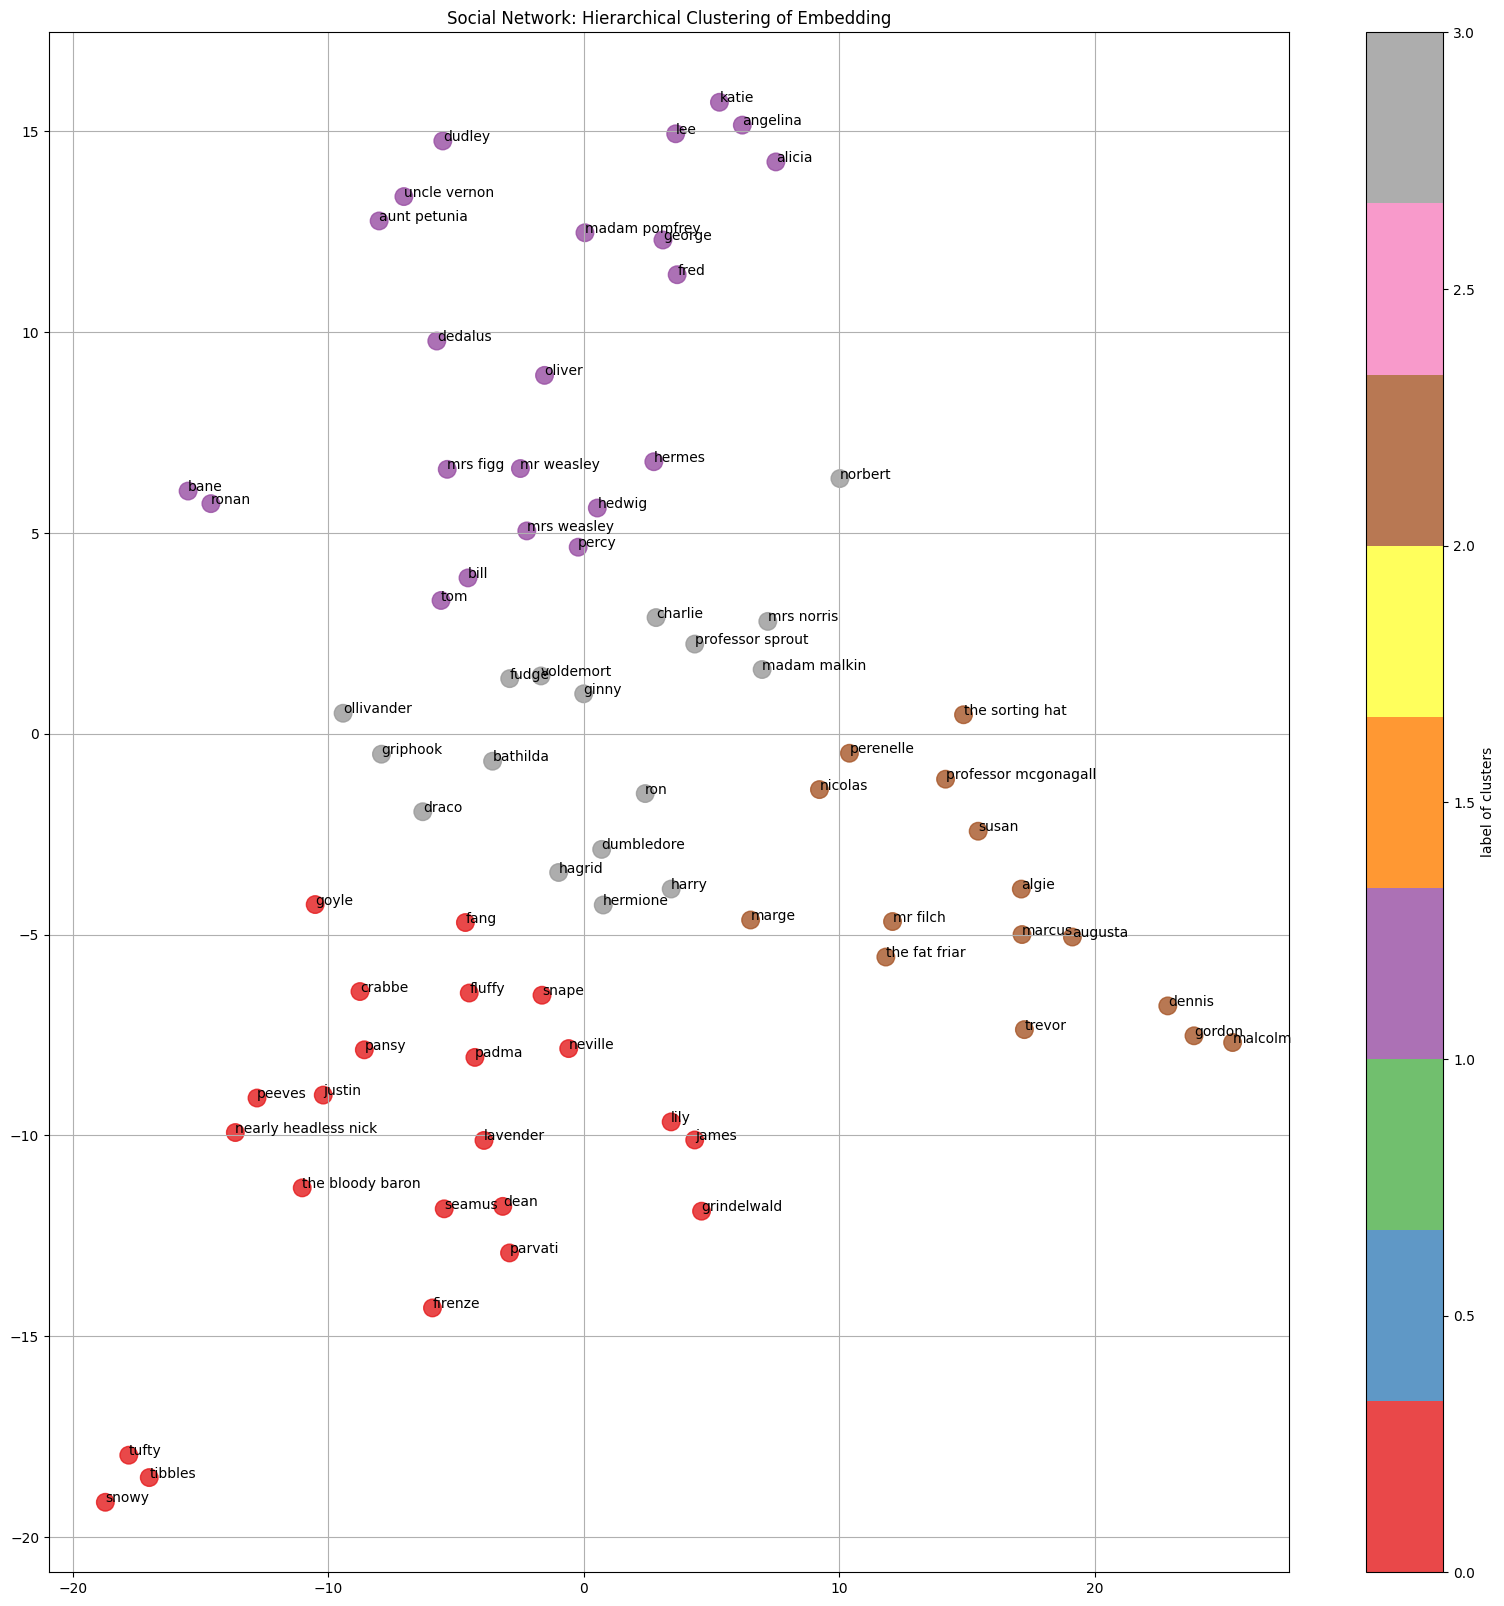

In [172]:
# Hierarchical clustering in the embedding space with node labels
plt.figure(figsize=(20, 20))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=hierarchical_labels, cmap=plt.cm.Set1, alpha=0.8, s = 160)

# Add node labels
for i, node in enumerate(G_sent.nodes()):
    plt.text(embeddings_2d[i, 0], embeddings_2d[i, 1], node, fontsize=10)

plt.title('Social Network: Hierarchical Clustering of Embedding')

plt.colorbar(label='label of clusters')
plt.grid('off')
plt.savefig('./images/social_network/sn_hierarchical.png')
plt.show()

Overall one could say that Embedding and Clustering is the better approach for the social network for defining groups of characters. Community detection seems to need more information about the characters than only sentiment analysis.